<a href="https://colab.research.google.com/github/Erike-Simon/CESAR-AED/blob/main/TempSeries_aula4_metricas_desempenho.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Métricas de desempenho

### Configurações iniciais

In [ ]:
pip install yfinance pydataset pmdarima tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 30.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 94.2 MB/s eta 0:00:00
  Created wheel for pydataset: filename=pydataset-0.2.0-py3-none-any.whl size=15939417 sha256=89a637355494a102933d816c55fadb5a29e2e7c0a75497ab072666583923cda3
  Stored in directory: /root/.cache/pip/wheels/2b/83/5c/073c3755e8b7704e4677557b2055e61026c1a2342149214c13
Successfully built pydataset


In [ ]:
import yfinance as yf
from pydataset import data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import KPSSTest, auto_arima
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor

initiated datasets repo at: /root/.pydataset/


Obtenção dos datasets

In [ ]:
def get_yfinance(id_name):
  df = yf.Ticker(id_name)
  df = df.history(period='max')
  return df['Close']

id_name = 'ITSA4.SA'
serie_itausa = get_yfinance(id_name)

In [ ]:
df_air = data('AirPassengers')
df_air['date'] = pd.date_range(
    start='1949-01-01', end= '1961-01-01', freq='M'
  )
df_air.set_index('date', inplace=True)
serie_air = df_air['AirPassengers']

Funções para cálculo de métricas

In [ ]:
def mean_square_error(y_true, y_pred):
    y_true = np.asmatrix(y_true).reshape(-1)
    y_pred = np.asmatrix(y_pred).reshape(-1)

    return np.square(np.subtract(y_true, y_pred)).mean()

def root_mean_square_error(y_true, y_pred):

    return mean_square_error(y_true, y_pred)**0.5


def mean_absolute_percentage_error(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    if len(np.where(y_true == 0)[0]) > 0:
        return np.inf
    else:
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def mean_absolute_error(y_true, y_pred):

    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    return np.mean(np.abs(y_true - y_pred))


def u_theil(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    error_sup = np.square(np.subtract(y_true, y_pred)).sum()
    error_inf = np.square(np.subtract(y_pred[0:(len(y_pred) - 1)], y_pred[1:(len(y_pred))])).sum()

    return error_sup / error_inf


def average_relative_variance(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    mean = np.mean(y_true)

    error_sup = np.square(np.subtract(y_true, y_pred)).sum()
    error_inf = np.square(np.subtract(y_pred, mean)).sum()

    return error_sup / error_inf


def prediction_of_change_in_direction(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    true_sub = np.subtract(y_true[0:(len(y_true) - 1)], y_true[1:(len(y_true))])
    pred_sub = np.subtract(y_pred[0:(len(y_pred) - 1)], y_pred[1:(len(y_pred))])

    mult = true_sub * pred_sub
    result = 0
    for m in mult:
        if m > 0:
            result = result + 1

    return (100 * (result / len(y_true)))


def gerenerate_metric_results(y_true, y_pred):
    return {'MSE': mean_square_error(y_true, y_pred),
            'RMSE':root_mean_square_error(y_true, y_pred),
            'MAPE': mean_absolute_percentage_error(y_true, y_pred),
            'MAE': mean_absolute_error(y_true, y_pred),
            'theil': u_theil(y_true, y_pred),
            'ARV': average_relative_variance(y_true, y_pred),
            'POCID': prediction_of_change_in_direction(y_true, y_pred)}


Função para treino e predição de um modelo baseado em auto.arima para uma série temporal

In [ ]:
def arima_fit_predict(ts, m, horizon, test_size):
  ts_train = ts[0:-(test_size+(horizon-1))].values
  ts_test = ts[-(test_size+(horizon-1)):].values

  model = auto_arima(ts_train, #X=None,
            start_p=2, start_q=2, max_p=5, max_d=2,
            max_q=5, start_P=1, start_Q=1, max_P=2,
            max_D=1, max_Q=2, max_order=10, m=m,
            stepwise=True, trace=True)

  direct_predict = model.predict(ts_test.shape[0])

  prevs_h_steps = []

  for t in tqdm(ts_test):
    prevs_h_steps.append(model.predict(horizon)[horizon-1])
    model.update(t)

  return prevs_h_steps[0:test_size], direct_predict[-test_size:]



### Treinamento e métricas para a série airlines

In [ ]:
test_size = 24
m = 12
horizon = 1
ts = serie_air
prevs_h_steps, direct_predict = arima_fit_predict(ts, m, horizon, test_size)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=813.750, Time=4.83 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=910.236, Time=0.06 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=810.646, Time=1.54 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=860.575, Time=0.65 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1060.479, Time=0.04 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=809.411, Time=0.15 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=810.721, Time=0.60 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=812.509, Time=2.24 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=808.863, Time=0.27 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=810.482, Time=1.28 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=810.553, Time=0.79 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.49 sec
 ARIMA(3,0,0)(0,1,0)[12] intercept   : AIC=809.375, Time=0.50 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=809.672, Time=0.44 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept  

100%|██████████| 24/24 [00:05<00:00,  4.02it/s]


<Axes: xlabel='date'>

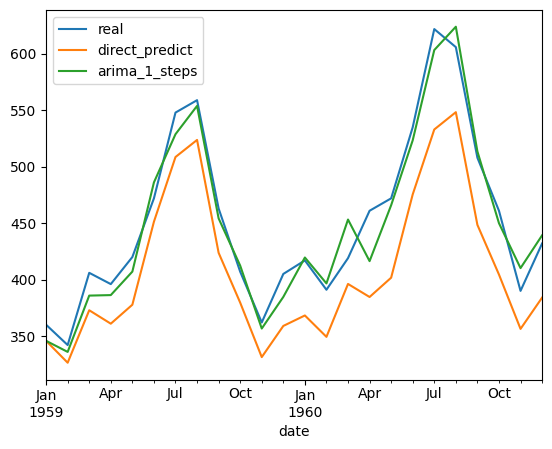

In [ ]:
df_result = pd.DataFrame(
    {
        'real': ts.iloc[-test_size:],
        'direct_predict': direct_predict,
        'arima_1_steps': prevs_h_steps,
    }
)
df_result.plot()

In [ ]:
y_true = ts.iloc[-test_size:]
metric_results = []
for model_name in ['direct_predict', 'arima_1_steps']:
  y_true = df_result['real']
  y_pred = df_result[model_name]
  dict_result = gerenerate_metric_results(y_true, y_pred)
  dict_result['model_name'] = model_name
  metric_results.append(dict_result)

In [ ]:
pd.DataFrame(metric_results)

,MSE,RMSE,MAPE,MAE,theil,ARV,POCID,model_name
0,2230.332101,47.226392,9.439333,43.464894,0.991340,0.367821,87.500000,direct_predict
1,279.571872,16.720403,3.043496,13.619108,0.103411,0.048930,83.333333,arima_1_steps


### Treinamento e métricas para a série itausa

In [ ]:
test_size = 365
m = 1
horizon = 1
ts = serie_itausa.iloc[-1825:]
prevs_1_steps_itausa, direct_predict_itausa = arima_fit_predict(ts, m, horizon, test_size)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1694.495, Time=3.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1673.889, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1678.263, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1677.868, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1675.394, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1677.905, Time=1.53 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1675.726, Time=1.38 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-1692.629, Time=5.63 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-1692.638, Time=3.28 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1677.186, Time=0.80 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-1682.028, Time=3.24 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-1673.783, Time=0.61 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-1691.230, Time=6.37 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-1696.037, Time=1.75 sec
 ARIMA(1,1,2)(0,0,0

100%|██████████| 365/365 [01:46<00:00,  3.42it/s]


<Axes: xlabel='Date'>

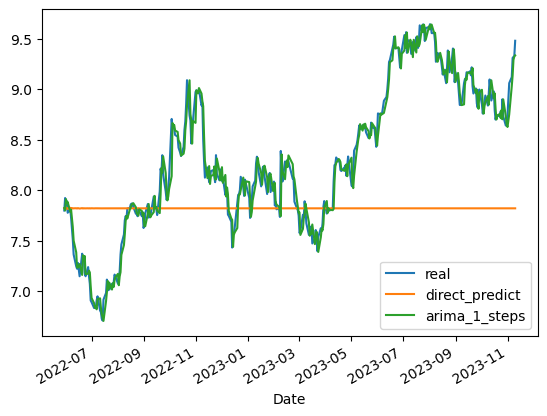

In [ ]:
df_result_itausa = pd.DataFrame(
    {
        'real': ts.iloc[-test_size:],
        'direct_predict': direct_predict_itausa,
        'arima_1_steps': prevs_1_steps_itausa,
    }
)
df_result_itausa.plot()

In [ ]:
y_true = ts.iloc[-test_size:]
metric_results = []
for model_name in ['direct_predict', 'arima_1_steps']:
  y_true = df_result_itausa['real']
  y_pred = df_result_itausa[model_name]
  dict_result = gerenerate_metric_results(y_true, y_pred)
  dict_result['model_name'] = model_name
  metric_results.append(dict_result)

In [ ]:
pd.DataFrame(metric_results)

,MSE,RMSE,MAPE,MAE,theil,ARV,POCID,model_name
0,0.771113,0.878131,8.057565,0.696797,543829.746965,3.220132,39.452055,direct_predict
1,0.014560,0.120664,1.112877,0.092230,1.081488,0.027569,48.767123,arima_1_steps


## Previsão de Séries Temporais com Redes Neurais

In [ ]:
# Função para criação de janela temporal
def create_windowing(df, lag_size):
    final_df = None
    for i in range(0, (lag_size + 1)):
        serie = df.shift(i)
        if (i == 0):
            serie.columns = ['actual']
        else:
            serie.columns = [str('lag' + str(i))]

        final_df = pd.concat([serie, final_df], axis=1)

    return final_df.dropna()

# Função para subtração dos valores
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)

    return pd.Series(diff).values

# voltar a subtração
def inverse_diference(last_ob, value):
  return value + last_ob

# Obtêm a diferença
def get_inverse_diference(last_ob, value):
  return [inverse_diference(last_ob[i], value[i]) for i in range(0, len(value))]

# Função para treino e predição de modelos sklearn
def fit_predict_sklearn(test_size, lag_size, horizon,
                        ts, model, use_diff=False):

  # Condições para diferenciação da série
  if use_diff:
    ts_ajusted = difference(ts.values, interval=horizon)
  else:
    ts_ajusted = ts.to_list()

  # Chamada da função para criação da janela temporal
  ts_lagged = create_windowing(pd.DataFrame(ts_ajusted), lag_size+ (horizon-1))

  # Ajustes e formatação dos dados vindos da janela temporal
  horizon_cols = [f'actual_{i}' for i in range(1, horizon)]
  lags_cols = [f'lag_{i}' for i in reversed(range(1,lag_size+1))]
  ts_lagged.columns = lags_cols + horizon_cols + ['actual']
  ts_lagged.drop(columns=horizon_cols, inplace=True)

  # Divisão de treino e teste
  x_train = ts_lagged.iloc[0:-test_size].drop(columns='actual').values
  y_train = ts_lagged.iloc[0:-test_size]['actual'].values.reshape(-1,1)

  x_test = ts_lagged.iloc[-test_size:].drop(columns='actual').values

  # Normalização doa dados de treino e teste
  x_scale = MinMaxScaler()
  y_scale = MinMaxScaler()
  x_scale.fit(x_train)
  y_scale.fit(y_train)

  x_train_norm = x_scale.transform(x_train)
  x_test_norm = x_scale.transform(x_test)

  y_train_norm = y_scale.transform(y_train)

  # Treinamento e predição
  model.fit(x_train_norm, y_train_norm)
  model_prev = model.predict(x_test_norm)

  # Retornando para os valores dos rótulos ('actual') de teste na escala original
  model_prev = y_scale.inverse_transform(model_prev.reshape(-1,1)).flatten()

  if use_diff:
    last_ob = ts.values[-(test_size+horizon):-horizon]
    model_prev = get_inverse_diference(last_ob, model_prev)

  return model_prev

Testando as diferenciações

In [ ]:
test_value = np.random.random_sample(size=5)
diff_serie_x = difference(test_value, interval=1)

In [ ]:
print(test_value)

[0.58418468 0.55332059 0.52992314 0.79386524 0.73617936]


In [ ]:
print(diff_serie_x)

[-0.03086409 -0.02339745  0.26394209 -0.05768588]


In [ ]:
print(test_value[:-1])

[0.58418468 0.55332059 0.52992314 0.79386524]


In [ ]:
serie_x = np.random.random_sample(size=10)
diff_serie_x = difference(serie_x, interval=1)
print(serie_x)
print(f'serie diff: {diff_serie_x}')

[0.24659239 0.07201175 0.27876924 0.0480406  0.40699432 0.40883497
 0.13688403 0.57449068 0.7805885  0.22274561]
serie diff: [-0.17458065  0.2067575  -0.23072864  0.35895373  0.00184064 -0.27195094
  0.43760665  0.20609783 -0.55784289]


Treinamento e teste com o modelo de regressão MLP

In [ ]:
# Parâmetros
test_size = 24
lag_size = 12
horizon = 1
ts = serie_air
model = MLPRegressor(solver = 'lbfgs') # 'solver' especifica o algoritmo a ser usado para otimizar os pesos da rede durante o treinamento
                                       # 'lbfgs' é frequentemente adequado para conjuntos de dados de tamanho pequeno a médio

# Chamada das funções para treinamento e predição
mlp_1step = fit_predict_sklearn(test_size, lag_size, horizon, ts, model)
mlp_1step_diff = fit_predict_sklearn(test_size, lag_size, horizon,
                                     ts, model, use_diff=True)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Treinamento e teste com o modelo de regressão SVR

In [ ]:
from sklearn.svm import SVR

test_size = 24
lag_size = 12
horizon = 1
ts = serie_air
model = SVR(C=100)

svr_1step = fit_predict_sklearn(test_size, lag_size, horizon, ts, model)
svr_1step_diff = fit_predict_sklearn(test_size, lag_size, horizon,
                                     ts, model, use_diff=True)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Gráficos de desempenho relacionados aos dados das airlines

<Axes: xlabel='date'>

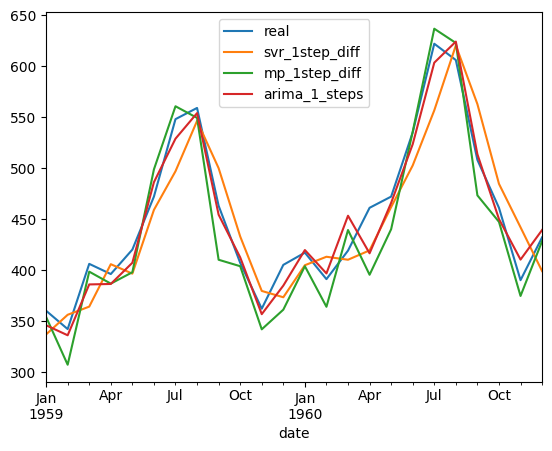

In [ ]:
df_result = pd.DataFrame(
    {
        'real': ts.iloc[-test_size:],
        'mlp_1_steps': mlp_1step,
        'svr_1step': svr_1step,
        'mp_1step_diff': mlp_1step_diff,
        'svr_1step_diff': svr_1step_diff,
        'arima_1_steps': prevs_h_steps,
    }
)
df_result[['real', 'svr_1step_diff', 'mp_1step_diff', 'arima_1_steps']].plot()

Métricas de desempenho

In [ ]:
y_true = ts.iloc[-test_size:]
metric_results = []
for model_name in ['mlp_1_steps', 'mp_1step_diff',
                   'svr_1step', 'svr_1step_diff', 'arima_1_steps']:

  y_true = df_result['real']
  y_pred = df_result[model_name]
  dict_result = gerenerate_metric_results(y_true, y_pred)
  dict_result['model_name'] = model_name
  metric_results.append(dict_result)

pd.DataFrame(metric_results)

,MSE,RMSE,MAPE,MAE,theil,ARV,POCID,model_name
0,3772.309466,61.419129,12.465661,56.767858,1.471012,0.489081,91.666667,mlp_1_steps
1,701.836538,26.492198,4.824276,21.174205,0.149868,0.093672,87.500000,mp_1step_diff
2,14657.499807,121.068162,21.818140,104.380751,37.285611,1.205272,70.833333,svr_1step
3,1036.783930,32.199129,6.169853,28.008788,0.561926,0.198447,62.500000,svr_1step_diff
4,279.571872,16.720403,3.043496,13.619108,0.103411,0.048930,83.333333,arima_1_steps


**Comparação entre os modelos de regressão SVR e MLP**

1. Capacidade de Generalização:

* O SVR é frequentemente considerado mais robusto em cenários com poucos dados de treinamento, pois pode evitar overfitting mais eficazmente.

2. Flexibilidade:

* MLPs podem ser mais flexíveis para modelar padrões complexos e relações não lineares.

3. Interpretabilidade:

* SVMs, incluindo o SVR, são geralmente mais fáceis de interpretar, especialmente quando se utiliza um kernel linear.

4. Ajuste de Hiperparâmetros:

* Ambos os modelos requerem ajuste de hiperparâmetros, mas a escolha de kernels e parâmetros do kernel no SVR pode ser uma tarefa mais desafiadora.

# PARTE DOIS: Lidando com a não estacionariedade manualmente